# Modelling Purchase Quantity

In this notebook, we build a statistical model which can estimate purchase quantity for each purchase. At this stage, we know that the customer have chosen a product from a brand in a specific product category. What is left to decide is number of units they want to buy.

Following the law of demand, the greater the unit price of a product, the lower the purchase quantity. For a car, the quantity difference may be from one to zero e.g. if the price of a Tesla is acceptable then we would buy one unit, otherwise we would not any. Other low price products such as chocolate bars, we may consider buying zero, one or even 10 at once. Calculating price elasticities will show us exactly, how the purchase quantities move with the change in price.

## Code

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from sklearn.linear_model import LinearRegression

sns.set(style='whitegrid')

In [2]:
df_purchases = pd.read_csv('data/fmcg-store-purchases-augmented.csv', index_col=0)

segment_labels = pickle.load(open('models/segment-labels.pickle', 'rb'))

segment_colours = ['lightskyblue', 'red', 'gold', 'green']
segment_colour_palette = sns.color_palette(segment_colours)

In [3]:
def train_model(df_data: pd.DataFrame):
    X = df_data[['Price', 'Promotion']]
    y = df_data['Quantity']
    
    model = LinearRegression()
    model.fit(X, y)

    return model

def create_elasticity_data_frame(price_range_arr, price_elasticity):
    elasticity_data = np.concatenate([price_range_arr, price_elasticity], axis=1)
    return pd.DataFrame(elasticity_data, columns=['Price', 'Elasticity'])

def calc_elasticity_for_quantity(df: pd.DataFrame, promotion: int, segment: int = None, price_range=(0.5, 3.5)):
    # We are only interested in rows where customer bought one of more chocolates
    df_data = df[df['Incidence'] == 1]
    
    if segment is not None:
        df_data = df_data[df_data['Segment'] == segment]
    
    model = train_model(df_data)
    
    # Generate test data
    price_range_arr = np.arange(price_range[0], price_range[1], 0.01).reshape(-1, 1)
    promotion_arr = np.ones(price_range_arr.shape[0]).reshape(-1, 1) * promotion
    X_test = np.concatenate([price_range_arr, promotion_arr], axis=1)
    
    # Generate predictions
    quantity_preds = model.predict(X_test).reshape(-1, 1)
    
    # Compute the elasticity
    price_coeff = model.coef_[0]
    price_elasticity = price_coeff * price_range_arr / quantity_preds
    
    return create_elasticity_data_frame(price_range_arr, price_elasticity)

## Linear Regression

To solve the problem, we use a Linear Regression model to predict number of units. The advantage of Linear Regression is that it is easy to interpret.

In [4]:
def calc_price(row):
    # Calculates the price of the selected brand
    brand = row['Brand']
    return 0 if brand == 0 else row[f'Price_{brand}']

def calc_promotion(row):
    brand = row['Brand']
    return 0 if brand == 0 else row[f'Promotion_{brand}']

df_purchases['Price'] = df_purchases.apply(calc_price, axis=1)
df_purchases['Promotion'] = df_purchases.apply(calc_promotion, axis=1)

In [5]:
df_data = df_purchases[df_purchases['Incidence'] == 1]

In [6]:
df_data[['Quantity']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,14638.0,2.774559,1.796736,1.0,2.0,2.0,3.0,15.0


There are several predictors that may influence purchase quantity:
- Price: the decision of the number of units is influenced by the price of the chosen brand and not the prices of the other brands. We need to filter this information as well. 
- Promotion may also influence purchase quantity.

Martial Status, Age, Education, Income, Occupation were used to predict the segment. Since the information in these features are already contained in our analysis, they will not be part of this model.

In [7]:
linear_model = train_model(df_data)

In [8]:
linear_model.coef_

array([-0.8173651 , -0.10504673])

The coefficients shows the change in the dependent variable that is going to occur with a unit change respective independent variables. 
For every 1.0 increase in price, the purchase quantity will decrease by 0.82. This is obvious. 
If there is a promotion, the purchase quantity will decrease by 0.11. The model says that people would
buy a bit less if there is a promotion. 
This unintuitive suggestion may have several plausible explanations:
- the model is very simplified because we only have two predictors.
- some important information is missing in our dataset
- we are only considering the average consumer and not consumers in a particular segment
- a promotion is prompting a consumer to try out a new brand. In this case, we do not expect consumers to buy many chocolate bars

With these hypothesis in mind, let us compute the price elasticity which is the percentage change in purchase quantity in response to a 1% change in the unit price of the chosen brand assuming that nothing else but the price changes. 

The process is as follows:
1. Fit a purchase quantity model: $f(\cdot)$
2. Assume that the price can take a wide range of values: $[p_1, p_2, \cdots, p_N]$
3. For each price point $p_i$, let the model predict the quantity $\hat{q}_i = f(p_i)$.
4. Using the predict quantity $\hat{q}_i$, calculate price elasticity for price $p_i$

In [9]:
df_pe_promo0 = calc_elasticity_for_quantity(df_purchases, promotion=0)
df_pe_promo1 = calc_elasticity_for_quantity(df_purchases, promotion=1)

In [10]:
min_price, max_price = df_data['Price'].min(), df_data['Price'].max()

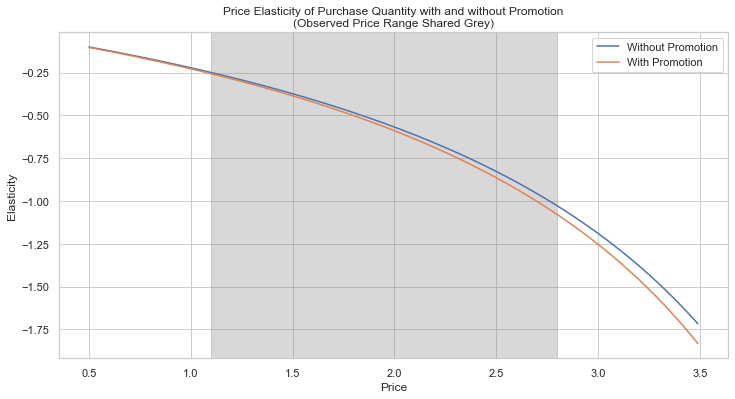

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_pe_promo0, label='Without Promotion', ax=ax)
sns.lineplot(x='Price', y='Elasticity', data=df_pe_promo1, label='With Promotion', ax=ax)
ax.axvspan(df_data['Price'].min(), df_data['Price'].max(), color='grey', alpha=0.3)
ax.set_title(
    'Price Elasticity of Purchase Quantity with and without Promotion\n'
    '(Observed Price Range Shared Grey)'
);

In the observed price range, customers are inelastic towards purchase quantity. There is a slight elasticity when there is a promotion. 
Promotion does not look like a big factor. The two curves practically overlap at many price points. 

Neither price nor promotion shifts appear to effect the consumers decision with respect to the quantity. The reasons could be:
- the variables that we included in our model might not hold any predictive value. Therefore, it seems like it does not make a lot of sense to focus too much on the purchase quantity.
- our methodology is wrong. The main concern is that we are estimating a model based on the average consumer despite know that there are four distinct segments. One idea is to calculate the price elasticity of demand for each brand.

